## Projeto 04 - Previsão do CHURN em uma Operadora de Telecom

## Definição do Problema de Negócio
Customer Churn (ou Rotatividade de Clientes, em uma tradução livre) refere-se a uma decisão tomada pelo cliente sobre o término do relacionamento comercial. Refere-se também a perda de clientes. A fidelidade do cliente e rotatividade de clientes sempre somam 100%. Se uma empresa tem uma taxa de fidelidade de 60%, então a taxa de perda de clientes é de 40%. De acordo com a regra de lucratividade do cliente 80/20, 20% dos clientes estão gerando 80% da receita. Portanto, é muito importante prever os usuários que provavelmente abandonarão o relacionamento comercial e os fatores que afetam as decisões do cliente.

Neste projeto,  vamos prever o Customer CHURN em uma Operadora de Telecom.

Nosso trabalho é criar um modelo de aprendizagem de máquina que possa prever se um cliente pode ou não cancelar seu plano e qual a probabilidade de isso ocorrer. O cabeçalho do dataset é uma descrição do tipo de informação em cada coluna e que será detalhado a seguir em nosso dicionário de dados.

## Dicionário de Dados
![title](Imagens/Tabela_dicionario_de_dados.png)

## Pacotes e Versões

In [1]:
# Registrando Versão Python
from platform import python_version
print('A Versão da Linguagem Python utilizada neste projeto é ', python_version())

A Versão da Linguagem Python utilizada neste projeto é  3.9.16


In [2]:
# Importando os Pacotes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import sklearn as sk
import imblearn as imb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from scipy.stats import shapiro

# Versão dos Pamcotes
%reload_ext watermark
%watermark -a "Thiago Bulgarelli" --iversions

Author: Thiago Bulgarelli

numpy     : 1.23.5
matplotlib: 3.6.2
imblearn  : 0.0
scipy     : 1.9.3
sklearn   : 1.0.2
seaborn   : 0.12.2
pandas    : 1.5.2



## Carregamento dos Dados
Os dados estão divididos em treino e teste pela fonte, porém vamos juntá-los em um único dataset para realizarmos nossas adequações. Vamos conferir os tipos de variáveis identificadas pelo interpretador da Linguagem Python, verificar se temos dados faltantes e por fim analisar como a variável resposta está distribuída, visto que temos aqui um problema de classificação binomial.

In [3]:
# Carregando os Dados
df = pd.concat([pd.read_csv('Dados/projeto4_telecom_treino.csv', sep=','),
                 pd.read_csv('Dados/projeto4_telecom_teste.csv', sep=',')], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 1666
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     5000 non-null   int64  
 1   state                          5000 non-null   object 
 2   account_length                 5000 non-null   int64  
 3   area_code                      5000 non-null   object 
 4   international_plan             5000 non-null   object 
 5   voice_mail_plan                5000 non-null   object 
 6   number_vmail_messages          5000 non-null   int64  
 7   total_day_minutes              5000 non-null   float64
 8   total_day_calls                5000 non-null   int64  
 9   total_day_charge               5000 non-null   float64
 10  total_eve_minutes              5000 non-null   float64
 11  total_eve_calls                5000 non-null   int64  
 12  total_eve_charge               5000 non-null   f

Nosso interpretador fez um bom trabalho identificando as variáveis numéricas e categóricas, sendo assim não temos alterações a fazer nesse momento. Vamos seguir com a organização...

In [4]:
# Criando um Dicionário DePara
DePara = {'Unnamed: 0' : 'ID',
          'state' : 'Estado',
          'account_length' : 'Dias_Ativo',
          'area_code' : 'Cod_Area',
          'international_plan' : 'Plano_Inter',
          'voice_mail_plan' : 'Plano_VSM',
          'number_vmail_messages':'Nr_Msgs_VM',
          'total_day_minutes' : 'Total_Min_Dia',
          'total_day_calls' : 'Total_Cham_Dia',
          'total_day_charge' : 'Total_Gasto_Dia',
          'total_eve_minutes' : 'Total_Min_Tarde',
          'total_eve_calls' : 'Total_Cham_Tarde',
          'total_eve_charge' : 'Total_Gasto_Tarde',
          'total_night_minutes' : 'Total_Min_Noite',
          'total_night_calls' : 'Total_Cham_Noite',
          'total_night_charge' : 'Total_Gasto_Noite',
          'total_intl_minutes' : 'Total_Min_Inter',
          'total_intl_calls' : 'Total_Cham_Inter',
          'total_intl_charge' : 'Total_Gasto_Inter',
          'number_customer_service_calls' : 'Total_Cham_Atend',
          'churn' : 'CHURN'}

In [5]:
# Renomeando as Colunas
df = df.rename(columns=DePara)
df.head()

,ID,Estado,Dias_Ativo,Cod_Area,Plano_Inter,Plano_VSM,Nr_Msgs_VM,Total_Min_Dia,Total_Cham_Dia,Total_Gasto_Dia,...,Total_Cham_Tarde,Total_Gasto_Tarde,Total_Min_Noite,Total_Cham_Noite,Total_Gasto_Noite,Total_Min_Inter,Total_Cham_Inter,Total_Gasto_Inter,Total_Cham_Atend,CHURN
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [6]:
# Verificando Ausência de Informação
df.isnull().sum() # Não temos dados faltantes

ID                   0
Estado               0
Dias_Ativo           0
Cod_Area             0
Plano_Inter          0
Plano_VSM            0
Nr_Msgs_VM           0
Total_Min_Dia        0
Total_Cham_Dia       0
Total_Gasto_Dia      0
Total_Min_Tarde      0
Total_Cham_Tarde     0
Total_Gasto_Tarde    0
Total_Min_Noite      0
Total_Cham_Noite     0
Total_Gasto_Noite    0
Total_Min_Inter      0
Total_Cham_Inter     0
Total_Gasto_Inter    0
Total_Cham_Atend     0
CHURN                0
dtype: int64

In [7]:
# Verificando a Distribuição da Variável Resposta CHURN
df.CHURN.value_counts()

no     4293
yes     707
Name: CHURN, dtype: int64

Podemos perceber que temos uma problema relacionado a distrubuição de dados referentes a variável resposta. Vamos precisar tratar o tema durante o Pré-processamento para evitar que tenhamos baixa performance do modelo preditivo.

## Análise Exploratória dos Dados
Vamos iniciar o estudo das variáveis e identificar como estão distribuídas, suas principais medidas estatísticas, suas distribuições e possíveis correlações entre si e variável resposta.

In [8]:
# Dividindo as variáveis em Numéricas e Categóricas
Cat = df.select_dtypes(include='object').columns
Num = df.select_dtypes(exclude='object').columns

### Variáveis Numéricas

In [9]:
# Dataset somente com as Variáveis Numéricas + Variável Resposta
VarNum = df[Num].iloc[:, 1:].join(df['CHURN'], how='right')

Vamos inicialmente olhar a big picture das variáves e então estudar individualmente aquelas que nos chamarem mais a atenção por suas características. Objetivo aqui é compreender melhor cada variável e retirar possíveis insights interessantes para nosso Negócio.

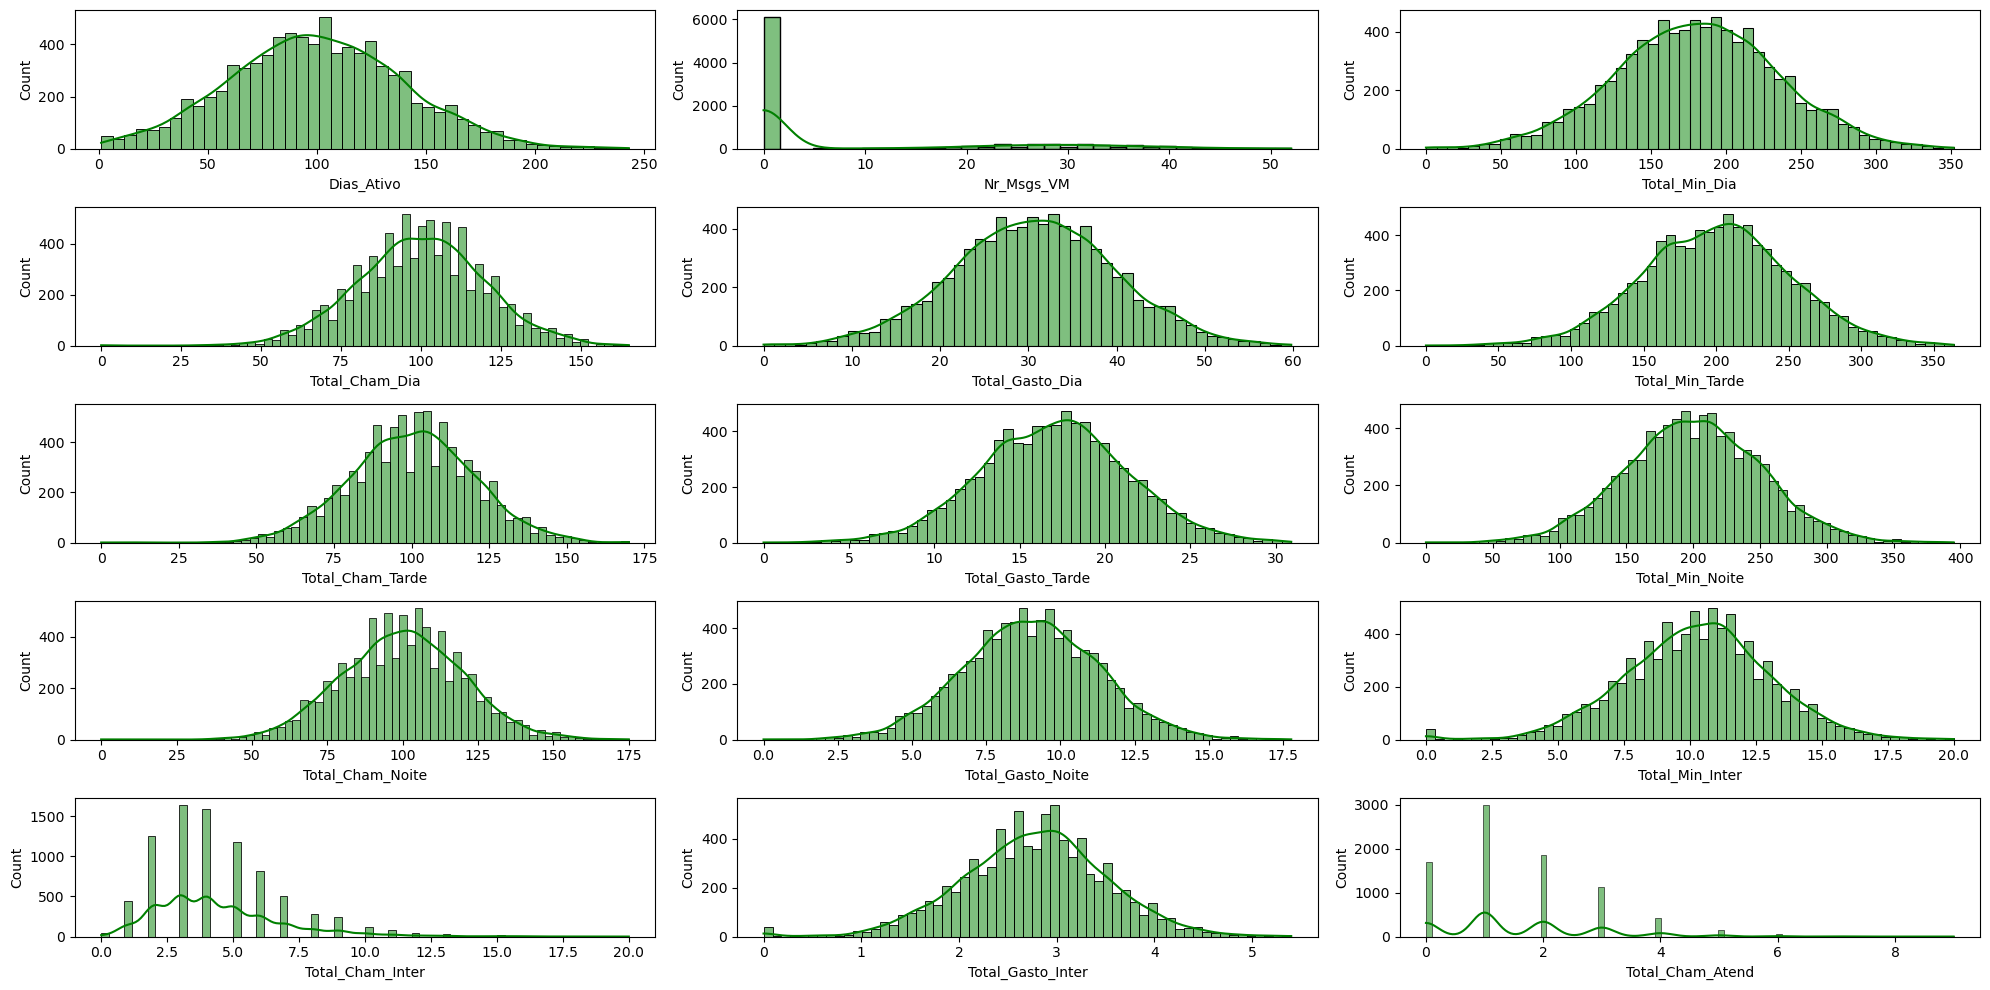

In [10]:
# Analisando as Distribuições das Variáveis
features = VarNum.columns[:-1]
plt.figure(figsize = (20, 10))
for i in range(0, len(features)):
    plt.subplot(5, len(features)//5, i+1)
    sns.histplot(x = VarNum[features[i]], kde = True, color = 'green')
    plt.xlabel(features[i])
    plt.tight_layout()

Podemos observar que as distribuições se aproximam de um Distribuição Normal em todas as variáveis. Vamos checar isso mais adiante para podermos afirmar estatísticamente.

**Observação** -> Percebemos que a quantidade de Mensagens de Voice Mail é zero na grande maioria dos usuários, portanto é um serviço muito pouco utilizado, provavelmente por que as pessoas hoje em dia preferem mandar mensagens por aplicativos e não por serviços de telefonia.

**Observação** -> O número de chamadas para o Atendimento também chama a atenção, temos muitos clientes com pelo menos 1 ou 2 chamadas para Atendimento, o que pode estar correlacionado a uma insatisfação do cliente.

Vamos explorar melhor os dois pontos quando estudarmos as variáveis separadamente.

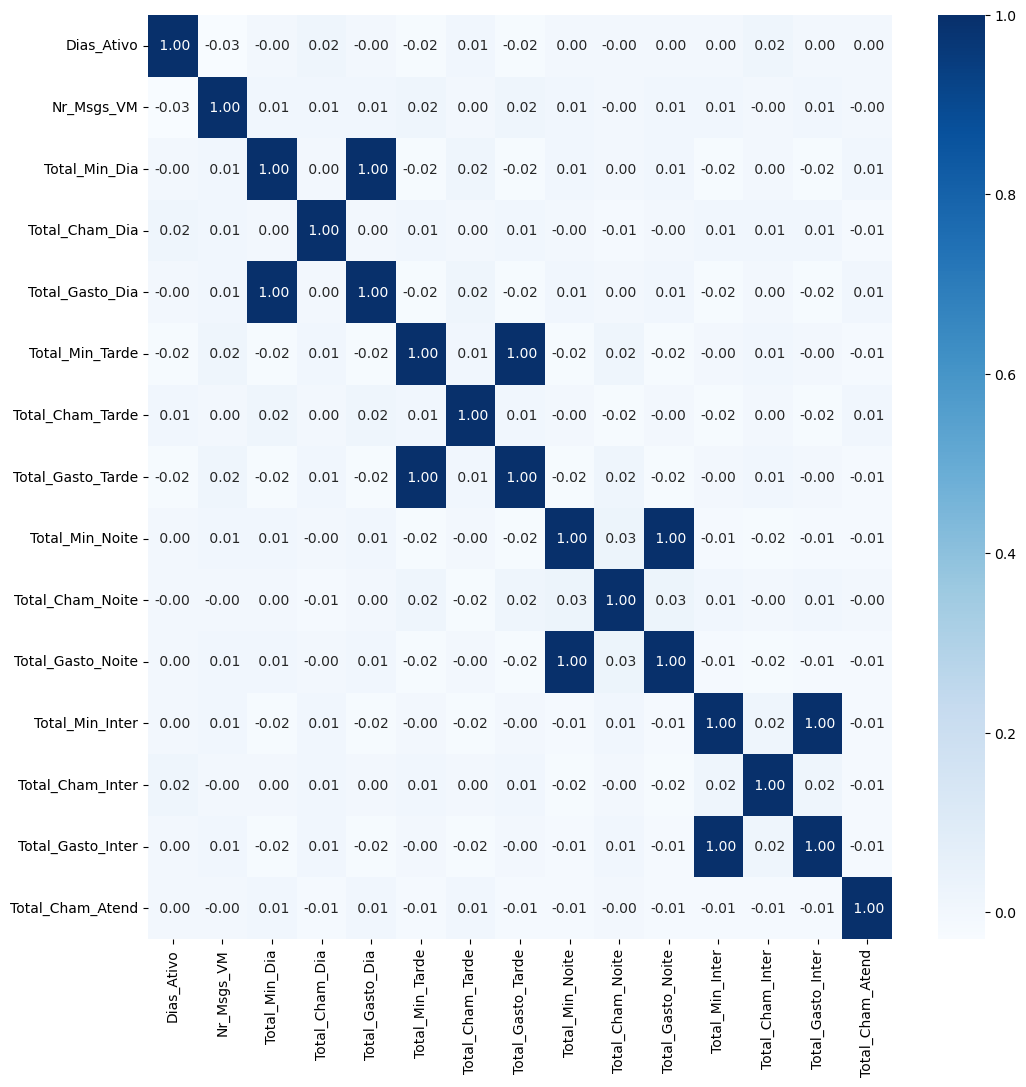

In [11]:
# Analisando a Corelação entre as Variáveis
CorrVarNum = round(VarNum.iloc[:, :-1].corr(), 2)
plt.figure(figsize=(12,12))
sns.heatmap(CorrVarNum, cmap='Blues', annot=True, fmt = ' .2f');

Percebemos no Heatmap que existem variáveis com multicolinearidade (Total_Gasto x Total_Min), ou seja, estão se correlacionando muito fortemente entre si. Isso ocorre pois as variáveis apresentam o mesmo tipo de informação, podendo então serem ou descartadas ou concatenadas em uma única informação. Vamos trabalhar com essas variáveis mais a frente no Pré-Processamento dos dados. O objetivo é manter a informação mas evitar a duplicidade, que pode tendenciar o aprendizado de nosso modelo preditivo.

#### Variável Dias_Ativo

In [12]:
# Medidas de Tendência Central para CHURN negativo
VarNum[(VarNum['CHURN']=='no')]['Dias_Ativo'].describe()

count    7192.00000
mean       99.66574
std        39.87100
min         1.00000
25%        73.00000
50%        99.00000
75%       127.00000
max       243.00000
Name: Dias_Ativo, dtype: float64

In [13]:
# Calculando a Mediana da Variável em Função do CHURN negativo
VarNum[(VarNum['CHURN']=='no')]['Dias_Ativo'].median()

99.0

In [14]:
# Medidas de Tendência Central para CHURN positivo
VarNum[(VarNum['CHURN']=='yes')]['Dias_Ativo'].describe()

count    1142.000000
mean      101.101576
std        39.020458
min         1.000000
25%        74.000000
50%       100.000000
75%       127.000000
max       225.000000
Name: Dias_Ativo, dtype: float64

In [15]:
# Calculando a Mediana da Variável em Função do CHURN positivo
VarNum[(VarNum['CHURN']=='yes')]['Dias_Ativo'].median()

100.0

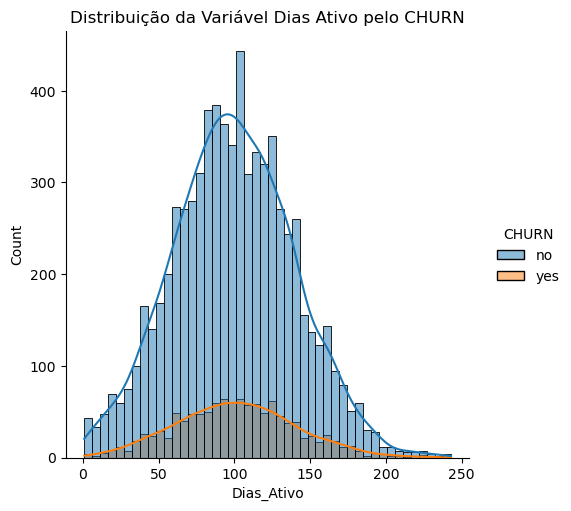

In [16]:
# Comparando as Distribuições Graficamente com base no CHURN
sns.displot(data=VarNum, x = 'Dias_Ativo', kde = True, hue='CHURN' )
plt.title('Distribuição da Variável Dias Ativo pelo CHURN');

**Observação**: Temos uma distribuição semelhante tanto para pessoas que se mantem no plano de telefonia (CHURN negativo), quanto para pessoas que sairam do plano (CHURN positivo). Na média as pessoas ficam 100 dias com esta operadora, no máximo 240 dias aproximadamente e com um desvio padrão de 39 dias. Aparentemente temos uma distribuição normal para ambas as situações de CHURN, visto que temos mediana muito próxima da média, mas vamos comprovar essa informação realizando um teste não paramétrico de Shapiro-Wilk.

    Sendo H0 -> Os dados seguem uma distribuição Normal
          H1 -> Os dados não seguem uma distribuição Normal

In [17]:
# Shapiro-Wilk Test para CHURN Positivo
shapiro(VarNum[(VarNum['CHURN']=='yes')]['Dias_Ativo'])

ShapiroResult(statistic=0.9974399209022522, pvalue=0.06757985800504684)

In [18]:
# Shapiro-Wilk Test para CHURN Negativo
shapiro(VarNum[(VarNum['CHURN']=='no')]['Dias_Ativo'].iloc[:4500])

ShapiroResult(statistic=0.9975619912147522, pvalue=1.3558333193941507e-06)

Para a situação de CHURN positivo ('yes') podemos afirmar que os dados seguem uma distribuição normal (falhamos em rejeitar H0, p-value = 0,067). Porém para CHURN negativo, rejeitamos H0 (p-value próximo de 0), o que não caracteriza uma distribuição Normal.

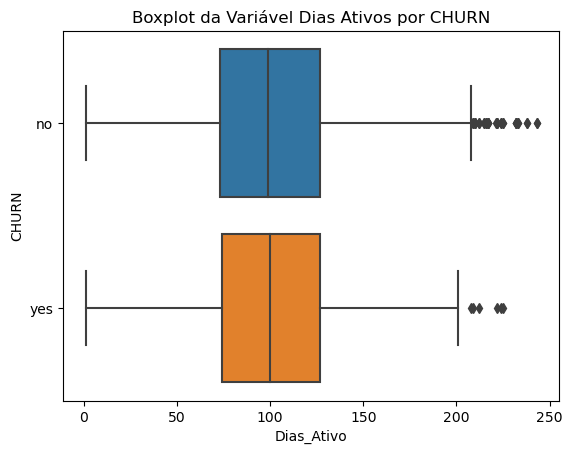

In [19]:
# Box plot por Categoria do CHURN
sns.boxplot(data=VarNum, x= 'Dias_Ativo', y='CHURN', orient='h')
plt.title('Boxplot da Variável Dias Ativos por CHURN');

Finalizamos com o Boxplot e comprovando que a Mediana se aproxima da média em ambos os casos porém não é suficiente para comprovar a distribuição normal pelo Teste de Hipótese.

#### Variável Nr_Msgs_VM

In [20]:
# Medidas de Tendência Central para CHURN negativo
VarNum[(VarNum['CHURN']=='no')]['Nr_Msgs_VM'].describe()

count    7192.000000
mean        8.096357
std        13.729524
min         0.000000
25%         0.000000
50%         0.000000
75%        19.000000
max        52.000000
Name: Nr_Msgs_VM, dtype: float64

In [21]:
# Calculando a Mediana da Variável em Função do CHURN negativo
VarNum[(VarNum['CHURN']=='no')]['Nr_Msgs_VM'].median()

0.0

In [22]:
# Medidas de Tendência Central para CHURN positivo
VarNum[(VarNum['CHURN']=='yes')]['Nr_Msgs_VM'].describe()

count    1142.000000
mean        5.705779
std        12.380441
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        49.000000
Name: Nr_Msgs_VM, dtype: float64

In [23]:
# Calculando a Mediana da Variável em Função do CHURN positivo
VarNum[(VarNum['CHURN']=='yes')]['Nr_Msgs_VM'].median()

0.0

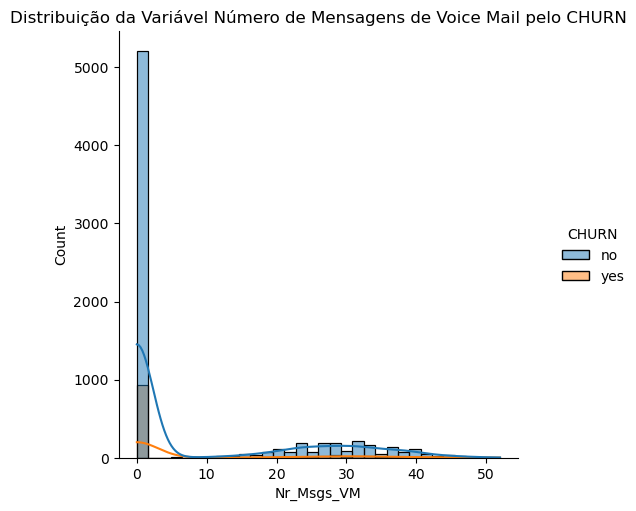

In [24]:
# Comparando as Distribuições Graficamente com base no CHURN
sns.displot(data=VarNum, x = 'Nr_Msgs_VM', kde = True, hue='CHURN' )
plt.title('Distribuição da Variável Número de Mensagens de Voice Mail pelo CHURN');

**Insight** -> É importante constatar que na grande maioria dos Clientes este serviço não é utilizado. No caso de pessoas que trocaram o Plano de Telefonia (CHURN "yes") vemos que praticamente 90% não utiliza o serviço. Talvez possamos reduzir o custo deste serviço em detrimento a oferecer outro serviço mais útil aos clientes.

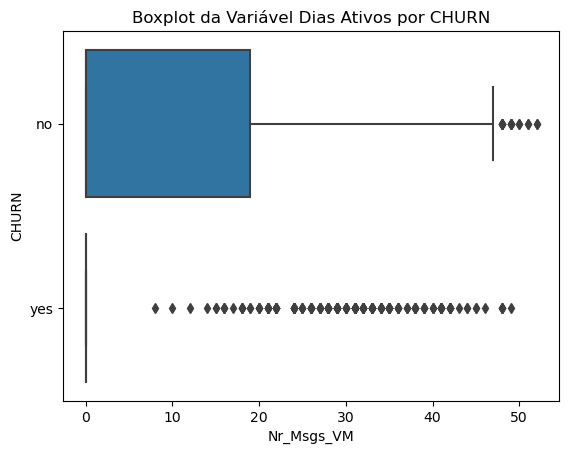

In [25]:
# Box plot por Categoria do CHURN
sns.boxplot(data=VarNum, x= 'Nr_Msgs_VM', y='CHURN', orient='h')
plt.title('Boxplot da Variável Dias Ativos por CHURN');

Claramente podemos observar que a Mediana para ambas as categorias de CHURN é 0.0, salvo alguns clientes que ainda usam este tipo de serviço.

#### Variáveis Total_Dia

Vamos analisar as variáveis referentes ao período do dia, visto que já identificamos que as mesmas se correlacionam. Vamos entender como se comportam

In [26]:
# Medidas de Tendência Central para CHURN negativo
VarNum[(VarNum['CHURN']=='no')].iloc[:, 2:5].describe()

,Total_Min_Dia,Total_Cham_Dia,Total_Gasto_Dia
count,7192.000000,7192.000000,7192.000000
mean,177.971732,99.849277,30.255755
std,51.304135,19.687266,8.721635
min,0.000000,0.000000,0.000000
25%,143.700000,87.000000,24.430000
50%,179.200000,100.000000,30.460000
75%,213.400000,113.000000,36.280000
max,350.800000,165.000000,59.640000


In [27]:
# Calculando a Mediana da Variável em Função do CHURN negativo
VarNum[(VarNum['CHURN']=='no')].iloc[:, 2:5].median()

Total_Min_Dia      179.20
Total_Cham_Dia     100.00
Total_Gasto_Dia     30.46
dtype: float64

In [28]:
# Medidas de Tendência Central para CHURN positivo
VarNum[(VarNum['CHURN']=='yes')].iloc[:, 2:5].describe()

,Total_Min_Dia,Total_Cham_Dia,Total_Gasto_Dia
count,1142.000000,1142.000000,1142.000000
mean,196.210858,100.337128,33.356349
std,64.883646,20.369875,11.030359
min,0.000000,0.000000,0.000000
25%,148.500000,88.000000,25.250000
50%,195.350000,101.000000,33.210000
75%,247.650000,114.000000,42.102500
max,351.500000,165.000000,59.760000


In [29]:
# Calculando a Mediana da Variável em Função do CHURN positivo
VarNum[(VarNum['CHURN']=='yes')].iloc[:, 2:5].median()

Total_Min_Dia      195.35
Total_Cham_Dia     101.00
Total_Gasto_Dia     33.21
dtype: float64

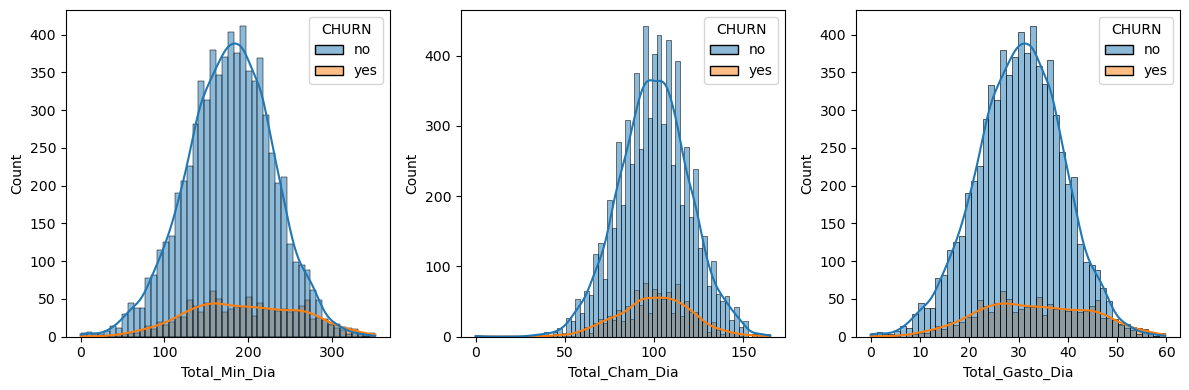

In [30]:
# Comparando as Distribuições Graficamente com base no CHURN
features = VarNum.columns[2:5]
plt.figure(figsize = (12, 4))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    sns.histplot(x = VarNum[features[i]], kde = True, hue=VarNum['CHURN'])
    plt.xlabel(features[i])
    plt.tight_layout()

Podemos perceber as 3 variáveis possuem comportamentos semelhantes, inclusive quando falamos de medidas de Tendência Central. Quando analisamos somente as observações de CHURN positivo, podemos perceber uma Kurtosis negativa, uma curva mais achatada e de mesma amplitude que as observações com CHURN negativo. Vamos comprovar calculando os coeficientes de Kurtosis e Skewness.

In [31]:
# Calculando os Coeficiente de Kurtosis e Skenewss das Variáveis Total_Dia com CHURN Negativo
dic = {}
dic['Kurtosis para CHURN Negativo'] = VarNum[(VarNum['CHURN']=='no')].iloc[:, 2:5].kurtosis()
dic['Kurtosis para CHURN Positivo'] = VarNum[(VarNum['CHURN']=='yes')].iloc[:, 2:5].kurtosis()
dic['Skewness para CHURN Negativo'] = VarNum[(VarNum['CHURN']=='no')].iloc[:, 2:5].skew()
dic['Skewness para CHURN Positivo'] = VarNum[(VarNum['CHURN']=='yes')].iloc[:, 2:5].skew()
Res = pd.DataFrame(data=dic)
Res

,Kurtosis para CHURN Negativo,Kurtosis para CHURN Positivo,Skewness para CHURN Negativo,Skewness para CHURN Positivo
Total_Min_Dia,0.019926,-0.632744,-0.119697,0.010501
Total_Cham_Dia,0.150802,0.768176,-0.061228,-0.226599
Total_Gasto_Dia,0.020030,-0.632665,-0.119708,0.010537


Então temos que no cados da Kurtosis com CHURN Negativo, valores próximos de zero, o que nos remete a uma maior proximidade com uma distribuição Normal, quando olhamos para o CHURN Positivo, identificamos 2 variáveis com valores negativos, ou seja, uma distribuição mais achatada que a Distribuição Normal.

**Insight** -> Por fim, o que nos chama a atenção no comportamento destas variáveis é que como as médias e medianas são próximas tanto para CHURN Negativo quanto para CHURN Positivo, podemos suspeitar que são variáveis com pouca influência no processo decisório do Cliente em permanecer ou não com os serviços da empresa.

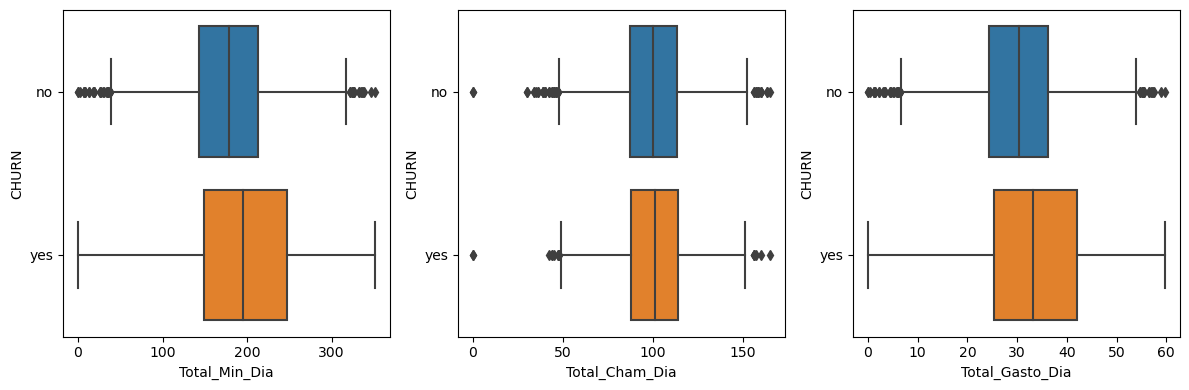

In [32]:
# Boxplot para Confirmar as proximidades da Média e Mediana
features = VarNum.columns[2:5]
plt.figure(figsize = (12, 4))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x = VarNum[features[i]], y=VarNum['CHURN'], orient='h')
    plt.xlabel(features[i])
    plt.tight_layout()

#### Variável Total_Tarde

De forma análoga as Variáveis do Total_Dia, vamos seguir com o mesmo raciocínio!

In [33]:
# Medidas de Tendência Central para CHURN negativo
VarNum[(VarNum['CHURN']=='no')].iloc[:, 5:8].describe()

,Total_Min_Tarde,Total_Cham_Tarde,Total_Gasto_Tarde
count,7192.000000,7192.000000,7192.000000
mean,199.330937,100.314794,16.943366
std,50.332369,19.798334,4.278229
min,0.000000,0.000000,0.000000
25%,165.300000,87.000000,14.050000
50%,200.000000,101.000000,17.000000
75%,232.500000,114.000000,19.760000
max,361.800000,170.000000,30.750000


In [34]:
# Calculando a Mediana da Variável em Função do CHURN negativo
VarNum[(VarNum['CHURN']=='no')].iloc[:, 5:8].median()

Total_Min_Tarde      200.0
Total_Cham_Tarde     101.0
Total_Gasto_Tarde     17.0
dtype: float64

In [35]:
# Medidas de Tendência Central para CHURN positivo
VarNum[(VarNum['CHURN']=='yes')].iloc[:, 5:8].describe()

,Total_Min_Tarde,Total_Cham_Tarde,Total_Gasto_Tarde
count,1142.000000,1142.000000,1142.000000
mean,206.622329,99.732925,17.562960
std,52.522994,19.510431,4.464411
min,58.300000,36.000000,4.960000
25%,169.900000,87.000000,14.440000
50%,208.350000,99.000000,17.710000
75%,243.675000,113.000000,20.710000
max,363.700000,168.000000,30.910000


In [36]:
# Calculando a Mediana da Variável em Função do CHURN positivo
VarNum[(VarNum['CHURN']=='yes')].iloc[:, 5:8].median()

Total_Min_Tarde      208.35
Total_Cham_Tarde      99.00
Total_Gasto_Tarde     17.71
dtype: float64

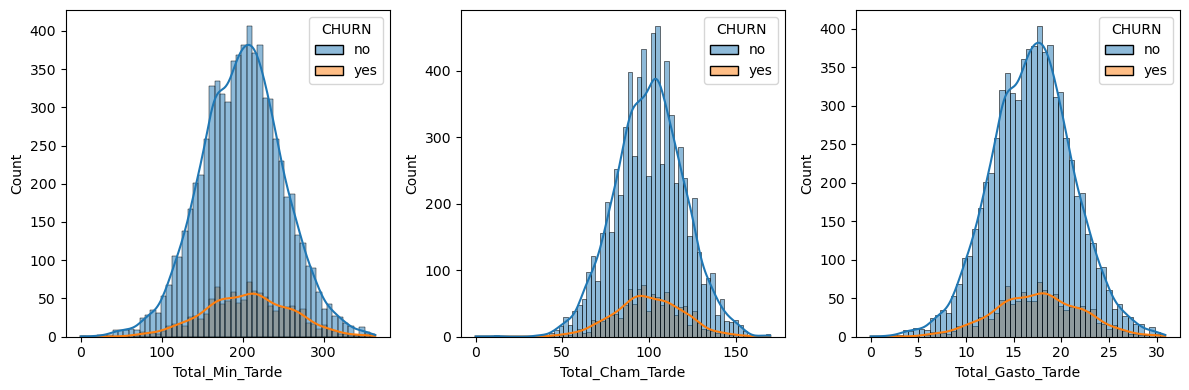

In [37]:
# Comparando as Distribuições Graficamente com base no CHURN
features = VarNum.columns[5:8]
plt.figure(figsize = (12, 4))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    sns.histplot(x = VarNum[features[i]], kde = True, hue=VarNum['CHURN'])
    plt.xlabel(features[i])
    plt.tight_layout()

Semelhante as variáveis Total_Dia, podemos perceber que as 3 variáveis possuem comportamentos semelhantes, inclusive quando falamos de medidas de Tendência Central. Quando analisamos somente as observações de CHURN positivo, podemos perceber uma Kurtosis negativa, uma curva mais achatada e de mesma amplitude que as observações com CHURN negativo. Vamos comprovar calculando os coeficientes de Kurtosis e Skewness.

In [38]:
# Calculando os Coeficiente de Kurtosis e Skenewss das Variáveis Total_Dia com CHURN Negativo
dic = {}
dic['Kurtosis para CHURN Negativo'] = VarNum[(VarNum['CHURN']=='no')].iloc[:, 5:8].kurtosis()
dic['Kurtosis para CHURN Positivo'] = VarNum[(VarNum['CHURN']=='yes')].iloc[:, 5:8].kurtosis()
dic['Skewness para CHURN Negativo'] = VarNum[(VarNum['CHURN']=='no')].iloc[:, 5:8].skew()
dic['Skewness para CHURN Positivo'] = VarNum[(VarNum['CHURN']=='yes')].iloc[:, 5:8].skew()
Res = pd.DataFrame(data=dic)
Res

,Kurtosis para CHURN Negativo,Kurtosis para CHURN Positivo,Skewness para CHURN Negativo,Skewness para CHURN Positivo
Total_Min_Tarde,0.117819,-0.196702,-0.027925,0.016287
Total_Cham_Tarde,0.100113,0.017120,-0.036369,0.002269
Total_Gasto_Tarde,0.117755,-0.196843,-0.027877,0.016399


Analisando o Skewness, temos distribuições muito próximas de zero, o que mostra uma simetria. Para as Kurtosis temos as mesmas características do Período do Dia, distribuições próximas de Normais para CHURN Negativo e um pouco mais achatadas para CHURN Positivo.

**Insight** -> Por fim, de forma análoga as variáveis Total_Dia, o que chama a atenção no comportamento destas variáveis é que como as médias e medianas são próximas tanto para CHURN Negativo quanto para CHURN Positivo, podemos suspeitar que são variáveis com pouca influência no processo decisório do Cliente em permanecer ou não com os serviços da empresa.

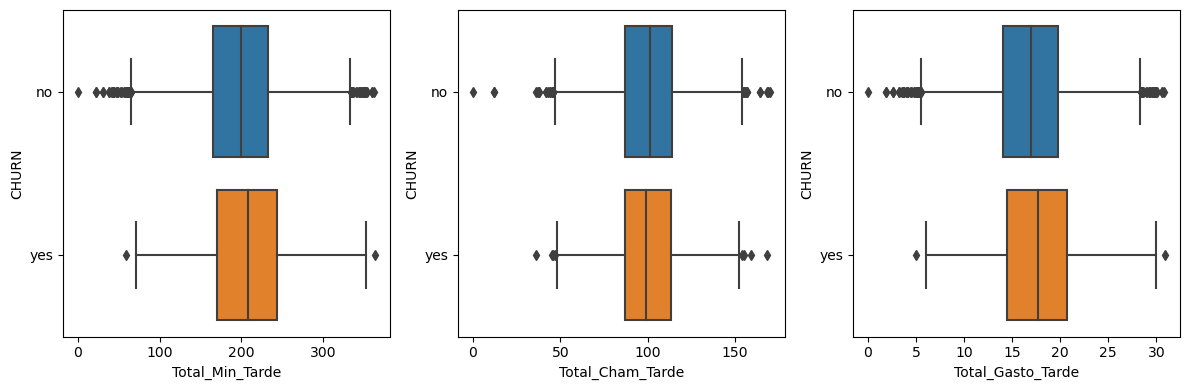

In [39]:
# Boxplot para Confirmar as proximidades da Média e Mediana
features = VarNum.columns[5:8]
plt.figure(figsize = (12, 4))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x = VarNum[features[i]], y=VarNum['CHURN'], orient='h')
    plt.xlabel(features[i])
    plt.tight_layout()

#### Variável Total_Noite

Vamos seguir da mesma forma que fizemos até o momento com as variáveis dos períodos Dia e Tarde.

In [40]:
# Medidas de Tendência Central para CHURN negativo
VarNum[(VarNum['CHURN']=='no')].iloc[:, 8:11].describe()

,Total_Min_Noite,Total_Cham_Noite,Total_Gasto_Noite
count,7192.000000,7192.000000,7192.000000
mean,199.645634,99.927976,8.984173
std,50.685747,19.943435,2.280855
min,0.000000,0.000000,0.000000
25%,166.200000,87.000000,7.480000
50%,199.500000,100.000000,8.980000
75%,233.850000,113.000000,10.522500
max,395.000000,175.000000,17.770000


In [41]:
# Calculando a Mediana da Variável em Função do CHURN negativo
VarNum[(VarNum['CHURN']=='no')].iloc[:, 8:11].median()

Total_Min_Noite      199.50
Total_Cham_Noite     100.00
Total_Gasto_Noite      8.98
dtype: float64

In [42]:
# Medidas de Tendência Central para CHURN positivo
VarNum[(VarNum['CHURN']=='yes')].iloc[:, 8:11].describe()

,Total_Min_Noite,Total_Cham_Noite,Total_Gasto_Noite
count,1142.000000,1142.000000,1142.000000
mean,203.162522,99.724168,9.142373
std,50.517638,20.379272,2.273330
min,47.400000,12.000000,2.130000
25%,169.800000,85.250000,7.640000
50%,203.450000,100.000000,9.155000
75%,238.225000,113.000000,10.722500
max,381.900000,160.000000,17.190000


In [43]:
# Calculando a Mediana da Variável em Função do CHURN positivo
VarNum[(VarNum['CHURN']=='yes')].iloc[:, 8:11].median()

Total_Min_Noite      203.450
Total_Cham_Noite     100.000
Total_Gasto_Noite      9.155
dtype: float64

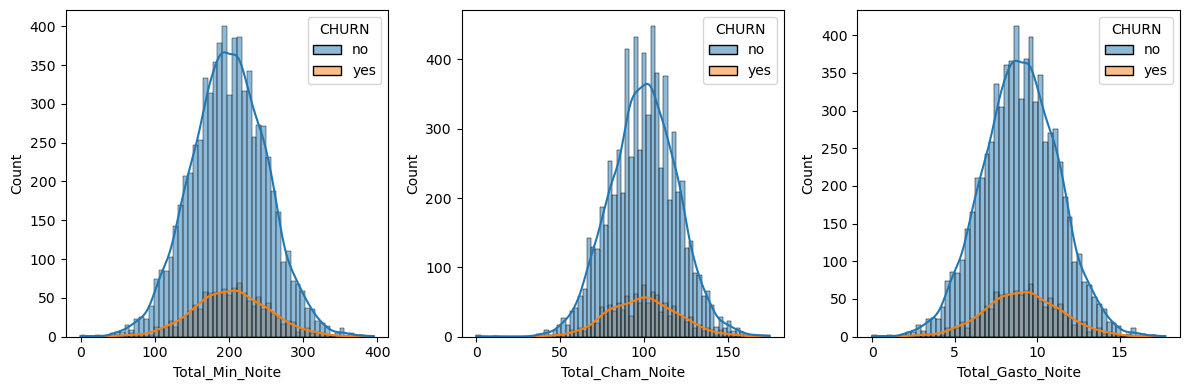

In [44]:
# Comparando as Distribuições Graficamente com base no CHURN
features = VarNum.columns[8:11]
plt.figure(figsize = (12, 4))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    sns.histplot(x = VarNum[features[i]], kde = True, hue=VarNum['CHURN'])
    plt.xlabel(features[i])
    plt.tight_layout()

Semelhante as variáveis dos Períodos Dia e Tarde, podemos perceber que as 3 variáveis possuem comportamentos semelhantes, inclusive quando falamos de medidas de Tendência Central. Quando analisamos somente as observações de CHURN positivo, podemos perceber uma Kurtosis negativa, uma curva mais achatada e de mesma amplitude que as observações com CHURN negativo. Vamos comprovar calculando os coeficientes de Kurtosis e Skewness.

In [45]:
# Calculando os Coeficiente de Kurtosis e Skenewss das Variáveis Total_Dia com CHURN Negativo
dic = {}
dic['Kurtosis para CHURN Negativo'] = VarNum[(VarNum['CHURN']=='no')].iloc[:, 8:11].kurtosis()
dic['Kurtosis para CHURN Positivo'] = VarNum[(VarNum['CHURN']=='yes')].iloc[:, 8:11].kurtosis()
dic['Skewness para CHURN Negativo'] = VarNum[(VarNum['CHURN']=='no')].iloc[:, 8:11].skew()
dic['Skewness para CHURN Positivo'] = VarNum[(VarNum['CHURN']=='yes')].iloc[:, 8:11].skew()
Res = pd.DataFrame(data=dic)
Res

,Kurtosis para CHURN Negativo,Kurtosis para CHURN Positivo,Skewness para CHURN Negativo,Skewness para CHURN Positivo
Total_Min_Noite,0.063903,0.213053,0.002524,0.090927
Total_Cham_Noite,0.196319,0.093716,-0.019809,0.051902
Total_Gasto_Noite,0.063925,0.213872,0.002536,0.090784


Analisando o Skewness, temos distribuições muito próximas de zero, o que mostra uma simetria. Para as Kurtosis temos todas as Distribuições próximas a Normal, tanto para CHURN Negativo e quanto para CHURN Positivo.

**Insight** -> Por fim, de forma análoga as variáveis Total_Dia e Total_Tarde, o que chama a atenção no comportamento destas variáveis é que como as médias e medianas são próximas tanto para CHURN Negativo quanto para CHURN Positivo, podemos suspeitar que são variáveis com pouca influência no processo decisório do Cliente em permanecer ou não com os serviços da empresa.

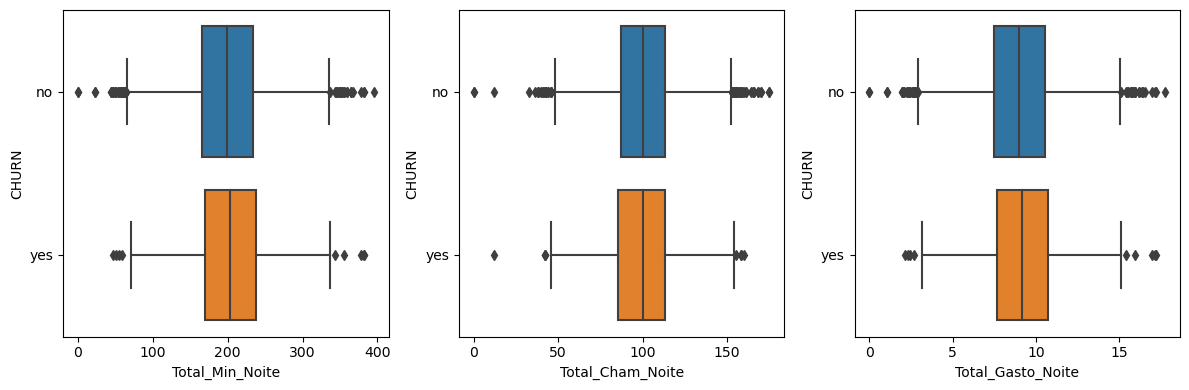

In [46]:
# Boxplot para Confirmar as proximidades da Média e Mediana
features = VarNum.columns[8:11]
plt.figure(figsize = (12, 4))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x = VarNum[features[i]], y=VarNum['CHURN'], orient='h')
    plt.xlabel(features[i])
    plt.tight_layout()

#### Variável Total_Inter

Vamos aplicar as mesmas análises referente aos Períodos do Dia, Tarde e Noite e verificar como as Chamadas Internacionais se comportam.

In [47]:
# Medidas de Tendência Central para CHURN negativo
VarNum[(VarNum['CHURN']=='no')].iloc[:, 11:14].describe()

,Total_Min_Inter,Total_Cham_Inter,Total_Gasto_Inter
count,7192.000000,7192.000000,7192.000000
mean,10.222720,4.462736,2.760642
std,2.750893,2.460197,0.742680
min,0.000000,0.000000,0.000000
25%,8.500000,3.000000,2.300000
50%,10.300000,4.000000,2.780000
75%,12.000000,6.000000,3.240000
max,20.000000,19.000000,5.400000


In [48]:
# Calculando a Mediana da Variável em Função do CHURN negativo
VarNum[(VarNum['CHURN']=='no')].iloc[:, 11:14].median()

Total_Min_Inter      10.30
Total_Cham_Inter      4.00
Total_Gasto_Inter     2.78
dtype: float64

In [49]:
# Medidas de Tendência Central para CHURN positivo
VarNum[(VarNum['CHURN']=='yes')].iloc[:, 11:14].describe()

,Total_Min_Inter,Total_Cham_Inter,Total_Gasto_Inter
count,1142.000000,1142.000000,1142.000000
mean,10.478109,4.234676,2.829641
std,2.794340,2.501026,0.754428
min,0.000000,0.000000,0.000000
25%,8.700000,2.000000,2.350000
50%,10.550000,4.000000,2.850000
75%,12.400000,5.000000,3.350000
max,20.000000,20.000000,5.400000


In [50]:
# Calculando a Mediana da Variável em Função do CHURN positivo
VarNum[(VarNum['CHURN']=='yes')].iloc[:, 11:14].median()

Total_Min_Inter      10.55
Total_Cham_Inter      4.00
Total_Gasto_Inter     2.85
dtype: float64

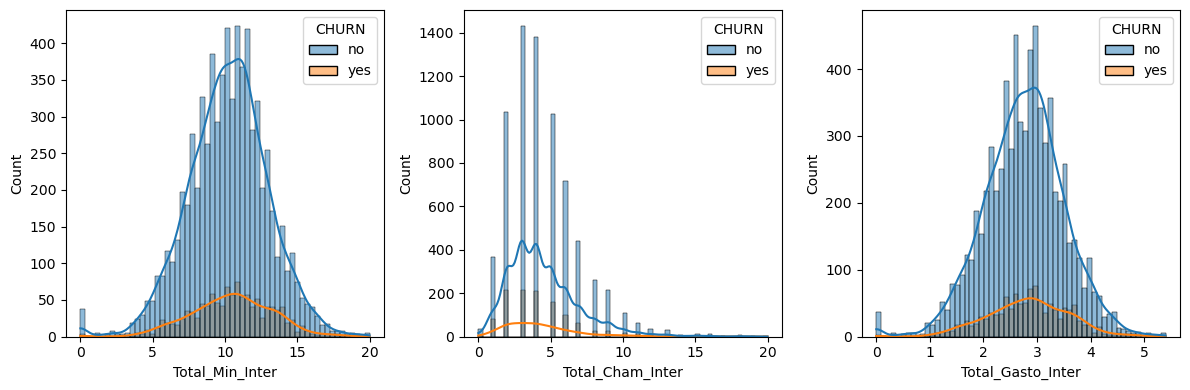

In [51]:
# Comparando as Distribuições Graficamente com base no CHURN
features = VarNum.columns[11:14]
plt.figure(figsize = (12, 4))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    sns.histplot(x = VarNum[features[i]], kde = True, hue=VarNum['CHURN'])
    plt.xlabel(features[i])
    plt.tight_layout()

  Podemos perceber que as variáveis Total_Min e Total_Gasto, possuem comportamento semelhante tanto para CHURN Positivo quanto para CHURN Negativo. Para a Variável Total_Cham, temos uma discrepância no comportamento dos gráficos, porém vamos confirmar calculando os coeficientes de Kurtosis e Skenewss.

In [52]:
# Calculando os Coeficiente de Kurtosis e Skenewss das Variáveis Total_Dia com CHURN Negativo
dic = {}
dic['Kurtosis para CHURN Negativo'] = VarNum[(VarNum['CHURN']=='no')].iloc[:, 11:14].kurtosis()
dic['Kurtosis para CHURN Positivo'] = VarNum[(VarNum['CHURN']=='yes')].iloc[:, 11:14].kurtosis()
dic['Skewness para CHURN Negativo'] = VarNum[(VarNum['CHURN']=='no')].iloc[:, 11:14].skew()
dic['Skewness para CHURN Positivo'] = VarNum[(VarNum['CHURN']=='yes')].iloc[:, 11:14].skew()
Res = pd.DataFrame(data=dic)
Res

,Kurtosis para CHURN Negativo,Kurtosis para CHURN Positivo,Skewness para CHURN Negativo,Skewness para CHURN Positivo
Total_Min_Inter,0.721851,0.345652,-0.201176,-0.123875
Total_Cham_Inter,3.148646,4.410804,1.346080,1.595644
Total_Gasto_Inter,0.722868,0.344596,-0.201484,-0.124144


Apesar de nossas suspeitas em relação a distribuição dos dados da variável Total_Cham, os coeficientes comprovam que possuem comportamentos semelhantes tanto em Kurtosis quanto em Skewness, com a Kurtosis um pouco mais elevada.

**Insight** -> Por fim, de forma análoga as variáveis dos Períodos, o que chama a atenção no comportamento destas variáveis é que como as médias e medianas são próximas tanto para CHURN Negativo quanto para CHURN Positivo. Porém, um ponto de atenção é a Variável Total_Cham_Inter, pois os quartis 25% e 75% com CHURN Positivo estão deslocados para baixo em relação ao CHURN Negativo, evidenciando que é um serviço menos utilizado pelas observações, apesar da Mediana e Média serem semelhantes.

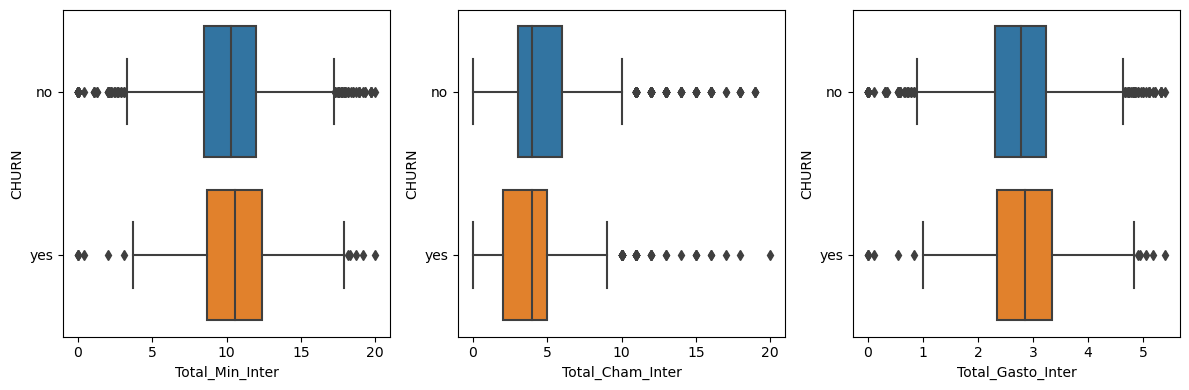

In [53]:
# Boxplot para Confirmar as proximidades da Média e Mediana
features = VarNum.columns[11:14]
plt.figure(figsize = (12, 4))
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x = VarNum[features[i]], y=VarNum['CHURN'], orient='h')
    plt.xlabel(features[i])
    plt.tight_layout()

#### Variável Total_Cham_Atend

Esta variável pode ter relação forte com o processo decisório do Cliente, vamos analisar!

In [54]:
# Medidas de Tendência Central para CHURN negativo
VarNum[(VarNum['CHURN']=='no')]['Total_Cham_Atend'].describe()

count    7192.000000
mean        1.498053
std         1.219595
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: Total_Cham_Atend, dtype: float64

In [55]:
# Medidas de Tendência Central para CHURN negativo
VarNum[(VarNum['CHURN']=='no')]['Total_Cham_Atend'].mode()

0    1
Name: Total_Cham_Atend, dtype: int64

In [56]:
# Medidas de Tendência Central para CHURN Positivo
VarNum[(VarNum['CHURN']=='yes')]['Total_Cham_Atend'].describe()

count    1142.000000
mean        2.014886
std         1.665957
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         9.000000
Name: Total_Cham_Atend, dtype: float64

In [57]:
# Medidas de Tendência Central para CHURN negativo
VarNum[(VarNum['CHURN']=='yes')]['Total_Cham_Atend'].mode()

0    1
Name: Total_Cham_Atend, dtype: int64

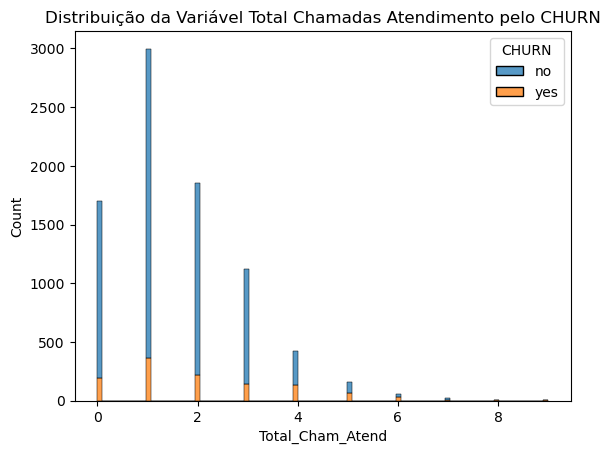

In [58]:
# Comparando as Distribuições Graficamente com base no CHURN - REFAZER
sns.histplot(data=VarNum, x = 'Total_Cham_Atend', hue='CHURN', fill=True, stat='count', cumulative=False, element='bars', multiple='stack')
plt.title('Distribuição da Variável Total Chamadas Atendimento pelo CHURN');

**Insight** -> Com os dados percebemos que a média de pessoas com CHURN positivo é 2 ligações. Para o CHURN Negativo, na média, considerando que não tempos 1,5 ligações, podemos considerar 2 ligações. O ponto de atenção aqui está na Moda, por ser mais representativa a Variável, onde claramente as pessoas ligaram 1 vez tanto para CHUR Positivo quanto para Negativo. Isso nos mostra que esta variável sozinha, nao caracteriza uma mudança de plano de telefonia. Um surpresa, pois era uma dúvida de negócio, quanto mais pessoas ligando para o SAC, mais insatisfação e por consequência maior o CHURN Positivo.

Finalizamos as variáveis numéricas, vamos então analisar as variáveis Categóricas.

### Variáveis Categóricas

In [59]:
# Dataset somente com as Variáveis Numéricas + Variável Resposta
VarCat = df[Cat]
VarCat

,Estado,Cod_Area,Plano_Inter,Plano_VSM,CHURN
0,KS,area_code_415,no,yes,no
1,OH,area_code_415,no,yes,no
2,NJ,area_code_415,no,no,no
3,OH,area_code_408,yes,no,no
4,OK,area_code_415,yes,no,no
...,...,...,...,...,...
1662,HI,area_code_408,no,yes,no
1663,WV,area_code_415,no,no,yes
1664,DC,area_code_415,no,no,no
1665,DC,area_code_510,no,no,no


#### Variável Cod_Area

In [60]:
# Quantidade de Observações por Código de Área
VarCat.groupby(['Cod_Area', 'CHURN']).count()

Estado  Plano_Inter  Plano_VSM
Cod_Area      CHURN                                
area_code_408 no       1082         1082       1082
              yes       177          177        177
area_code_415 no       2149         2149       2149
              yes       346          346        346
area_code_510 no       1062         1062       1062
              yes       184          184        184

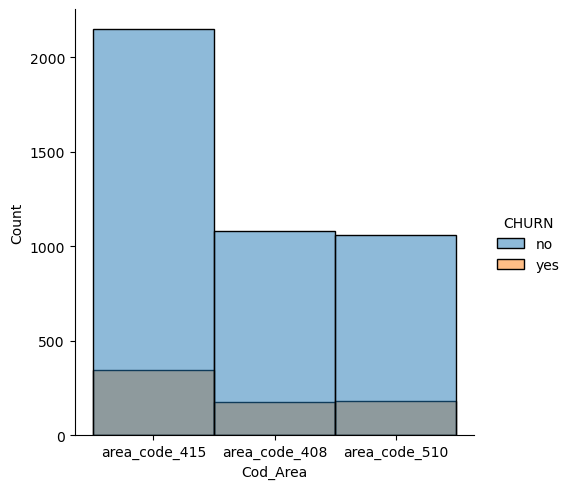

In [61]:
# Gráfico de Barras com a Contagem das Observações por Cod_Area e Categoria de CHURN
sns.displot(data=VarCat, x='Cod_Area', hue='CHURN');

In [62]:
# Calculando as proporções de cada estado
PropCA = pd.crosstab(index=VarCat['Cod_Area'], columns=VarCat['CHURN'])
PropCA['%CHURN']=round(PropCA['yes']/(PropCA['no']+PropCA['yes']), 2).sort_values(ascending=False)
PropCA['%CHURN'].sort_values(ascending=False).head(10)

Cod_Area
area_code_510    0.15
area_code_408    0.14
area_code_415    0.14
Name: %CHURN, dtype: float64

**Insight** -> Apesar do Cod de área 415 possuir um número absoluto maior de CHURN Positivo, quando relacionamos a quantidade de Clientes em cada área, percebemos que os códigos de area possuem um CHURN Positivo próximos, com uma leve superioridade do Cod de Area 510.

#### Variável Estado

In [63]:
# Quantidade de Observações por Estado
VarCat.groupby(['Estado', 'CHURN']).count()

Cod_Area  Plano_Inter  Plano_VSM
Estado CHURN                                  
AK     no           67           67         67
       yes           5            5          5
AL     no          111          111        111
       yes          13           13         13
AR     no           76           76         76
...                ...          ...        ...
WI     yes           8            8          8
WV     no          136          136        136
       yes          22           22         22
WY     no          104          104        104
       yes          11           11         11

[102 rows x 3 columns]

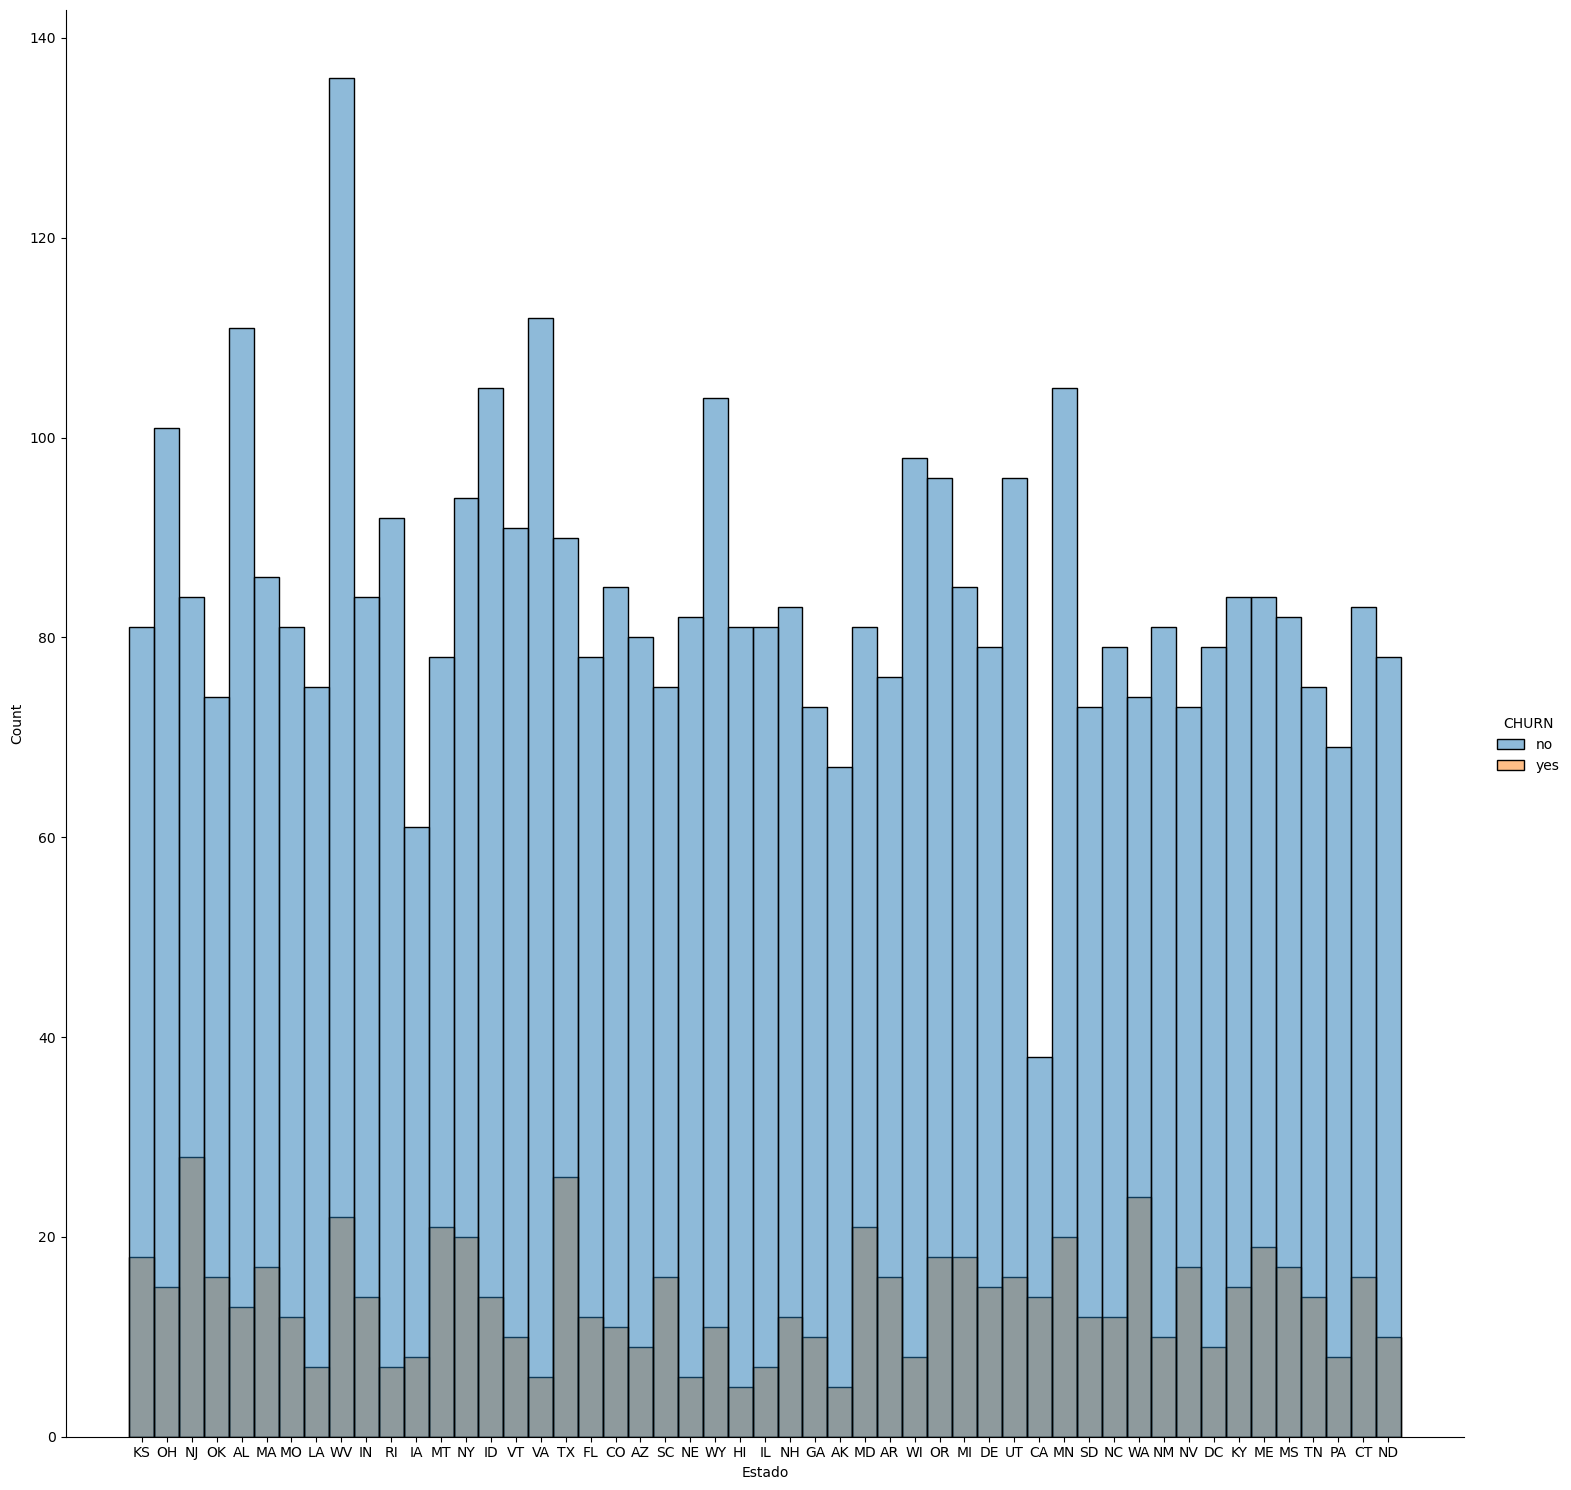

In [64]:
# Gráfico de Barras com a Contagem das Observações por Estado e Categoria de CHURN
sns.displot(data=VarCat, x='Estado', hue='CHURN', height=15, aspect=1, kind='hist');

In [65]:
# Calculando as proporções de cada estado
PropE = pd.crosstab(index=VarCat['Estado'], columns=VarCat['CHURN'])
PropE['%CHURN']=round(PropE['yes']/(PropE['no']+PropE['yes']), 2).sort_values(ascending=False)
PropE['%CHURN'].sort_values(ascending=False).head(10)

Estado
CA    0.27
NJ    0.25
WA    0.24
TX    0.22
MT    0.21
MD    0.21
NV    0.19
KS    0.18
OK    0.18
NY    0.18
Name: %CHURN, dtype: float64

**Insights** -> Alguns estados se destacam nessa nossa análise, com uma taxa de CHURN alta em relação ao total de clientes. Destacamos aqui os estados da Califórnia, New Jersy, Washington, Texas, Montana e Maryland com taxas acima de 20%.

#### Variável Plano_Inter

In [66]:
# Quantidade de Observações por Categoria do Plano Internacional
VarCat.groupby(['Plano_Inter', 'CHURN']).count()

Estado  Cod_Area  Plano_VSM
Plano_Inter CHURN                             
no          no       4019      4019       4019
            yes       508       508        508
yes         no        274       274        274
            yes       199       199        199

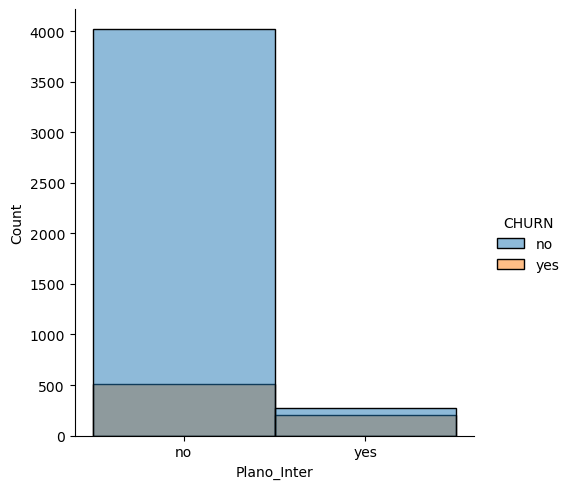

In [67]:
# Gráfico de Barras com a Contagem das Observações por Categoria de Plano Internacional e Categoria de CHURN
sns.displot(data=VarCat, x='Plano_Inter', hue='CHURN', kind='hist');

In [68]:
# Calculando as proporções de cada Categoria do Plano Internacional
PropPI = pd.crosstab(index=VarCat['Plano_Inter'], columns=VarCat['CHURN'])
PropPI['%CHURN']=round(PropPI['yes']/(PropPI['no']+PropPI['yes']), 2).sort_values(ascending=False)
PropPI['%CHURN'].sort_values(ascending=False).head(10)

Plano_Inter
yes    0.42
no     0.11
Name: %CHURN, dtype: float64

**Insights** -> Para a Variável Plano Internacional, percebemos que 42% dos Clientes com Plano Internacional, mudaram de Telefonia, ou seja, representam o CHURN Positivo. Essa é uma informação interessante pois pode ser um dos motivos pelo qual as pessoas ficam insatisfeitas.

#### Variável Plano_VSM

In [69]:
# Quantidade de Observações por Categoria do Plano de Voice Service Messenger
VarCat.groupby(['Plano_VSM', 'CHURN']).count()

Estado  Cod_Area  Plano_Inter
Plano_VSM CHURN                               
no        no       3072      3072         3072
          yes       605       605          605
yes       no       1221      1221         1221
          yes       102       102          102

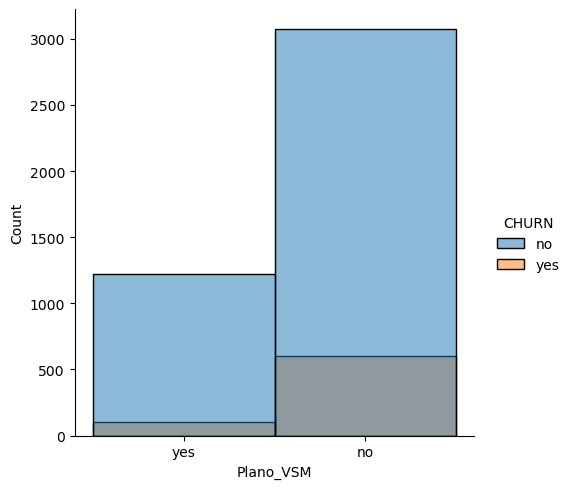

In [70]:
# Gráfico de Barras com a Contagem das Observações por Categoria do Plano de VSM e Categoria de CHURN
sns.displot(data=VarCat, x='Plano_VSM', hue='CHURN', kind='hist');

In [71]:
# Calculando as proporções de cada Categoria do Plano VSM
PropPV = pd.crosstab(index=VarCat['Plano_VSM'], columns=VarCat['CHURN'])
PropPV['%CHURN']=round(PropPV['yes']/(PropPV['no']+PropPV['yes']), 2).sort_values(ascending=False)
PropPV['%CHURN'].sort_values(ascending=False).head(10)

Plano_VSM
no     0.16
yes    0.08
Name: %CHURN, dtype: float64

**Insight** -> Para a variável relacionada ao uso de Voice Service Messenger, percebemos que o CHURN Positivo, não parece ter relação com o Serviço de Voice Messenger. Temos 8% de CHURN positivo para aqueles que usam o VSM, e 16% para aqueles que não usam o plano.

## Pré-Processamento dos Dados

Neste momento vamos iniciar a preparação de nossos dados para aplicação de modelagem preditiva. 

O primeiro passo é realizarmos Label Encoding das Variáveis Categóricas, depois aplicar uma técnica para equilibrar o número de observações da variável resposta, então aplicamos uma divisão aos dados em treino e teste e por fim faremos uma Padronização nos dados para equiparar as escalas de cada variável preditora.

### Feature Engineering
Como verificamos durante a análise de correlação na fase exploratória dos dados, existe multicolinearidade entre as variáveis Total_Min e Total_Gasto. Sendo assim vamos criar uma nova Variável de Taxa R$/Min para cada Período e depois retirar as Variáveis Total_Min e Total Gasto do dataset de modelagem.

Para as Variáveis relacionadas a Plano_Internacional, temos um situação diferente. Existe a mesma multicolinearidade entre Total_Min e Total_Gasto, porém calcular uma Variável nova de Taxa R$/min vai gerar dados NaN por divisão por zero. Isso vai ocorrer por que temos uma variável categórica de Sim e Não do Uso desse tipo de Plano. Como todas estas variáveis estão correlacionadas, vamos excluir Total_Min e a Categórica Plano_Inter, deixando Total_Cham_Inter e Total_Gasto_Inter. 

Acreditamos que desta forma, tendenciamos meno nosso modelo, reduzimos as dimensões simplificando mais nossa modelagem e aumentando a Generalização.

In [98]:
# Criando um Novo Dataset com as Variáveis Taxa_Dia, Taxa_Tarde, Taxa_Noite
df1 = df.copy()
df1['Taxa_Dia'] = round(df1['Total_Gasto_Dia']/df1['Total_Min_Dia'], 3)
df1['Taxa_Tarde'] = round(df1['Total_Gasto_Tarde']/df1['Total_Min_Tarde'], 3)
df1['Taxa_Noite'] = round(df1['Total_Gasto_Tarde']/df1['Total_Min_Noite'], 3)

# Verificando se temos Dados NaN
df1.isnull().sum()


ID                   0
Estado               0
Dias_Ativo           0
Cod_Area             0
Plano_Inter          0
Plano_VSM            0
Nr_Msgs_VM           0
Total_Min_Dia        0
Total_Cham_Dia       0
Total_Gasto_Dia      0
Total_Min_Tarde      0
Total_Cham_Tarde     0
Total_Gasto_Tarde    0
Total_Min_Noite      0
Total_Cham_Noite     0
Total_Gasto_Noite    0
Total_Min_Inter      0
Total_Cham_Inter     0
Total_Gasto_Inter    0
Total_Cham_Atend     0
CHURN                0
Taxa_Dia             2
Taxa_Tarde           1
Taxa_Noite           0
dtype: int64

In [99]:
# Excluindo os dados NaN gerados
df1.dropna(inplace=True)
df1.drop(index=1374, inplace=True)

# Excluindo as Variáveis que não usaremos
df1.drop(['Total_Min_Dia', 'Total_Gasto_Dia', 'Total_Min_Tarde', 'Total_Gasto_Tarde', 'Total_Min_Noite', 
          'Total_Gasto_Noite', 'Plano_Inter', 'Total_Min_Inter'],axis=1, inplace=True)


In [100]:
# Visualizando o Dataset Resultante e organizando a Variável Resposta no Final do Dataset
VR = df1['CHURN'].copy()
df1['CHURN1'] = VR
df1.drop(['CHURN'], axis=1, inplace=True)
df1.rename(columns={'CHURN1': 'CHURN'}, inplace=True)
df1.head()

,ID,Estado,Dias_Ativo,Cod_Area,Plano_VSM,Nr_Msgs_VM,Total_Cham_Dia,Total_Cham_Tarde,Total_Cham_Noite,Total_Cham_Inter,Total_Gasto_Inter,Total_Cham_Atend,Taxa_Dia,Taxa_Tarde,Taxa_Noite,CHURN
0,1,KS,128,area_code_415,yes,25,110,99,91,3,2.70,1,0.17,0.085,0.069,no
1,2,OH,107,area_code_415,yes,26,123,103,103,3,3.70,1,0.17,0.085,0.065,no
2,3,NJ,137,area_code_415,no,0,114,110,104,5,3.29,0,0.17,0.085,0.063,no
3,4,OH,84,area_code_408,no,0,71,88,89,7,1.78,2,0.17,0.085,0.027,no
4,5,OK,75,area_code_415,no,0,113,122,121,3,2.73,3,0.17,0.085,0.067,no


### Aplicando Técnica de Label Encoding

In [101]:
# Listando as Variáveis Categóricas
VarCat.describe()

,Estado,Cod_Area,Plano_Inter,Plano_VSM,CHURN
count,5000,5000,5000,5000,5000
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,158,2495,4527,3677,4293


O que podemos observar é que temos na Variável Estado 51 valores únicos. Aqui nao cabe a técnica de Label Encoding, devido a quantidade enorme de fatores que seriam criados. Também nao seria interessante aplicar One-Hot Encoding, pois aumentaríamos em 51 variáveis nosso projeto e consequentemente a complexidade do modelo a ser desenvolvido. 

Outro ponto é a representatividade geográfica desta variável, que pode ser representada pela Variável Codigo de Área, mantendo ao menos 1 tipo de informação geoposicional em nossa modelagem. Por estes detalhes, vamos desconsiderar o uso da Variável Estado, mantendo as Variáveis Cod_Area e Plano_VSM.

A variável resposta CHURN, também precisa receber o tratamento de Label Encoding, e também será tratada agora.

In [102]:
# Verificando os valores únicos da Variável Cod_Area
df1['Cod_Area'].value_counts()

area_code_415    2492
area_code_408    1258
area_code_510    1245
Name: Cod_Area, dtype: int64

In [103]:
# Copiando o df e dropando as Colunas que não serão utilizadas daqui em diante (ID, Estado)
df1.drop(['ID', 'Estado'], axis=1, inplace=True)



In [104]:
# Criando modelo de Label Encoding Cod Area
Label = LabelEncoder().fit(df1['Cod_Area'])
Label.classes_


array(['area_code_408', 'area_code_415', 'area_code_510'], dtype=object)

In [105]:
# Aplicando Modelo na Variável Cod Area
df1['Cod_Area'] = Label.transform(df1['Cod_Area'])
df1['Cod_Area'].value_counts()

1    2492
0    1258
2    1245
Name: Cod_Area, dtype: int64

Para a Variável Cod_Area ficamos com o Label Encoding da seguinte forma:
- area_code_408 -> 0
- area_code_415 -> 1
- area_code_510 -> 2

In [106]:
# Verificando os valores únicos da Variável Plano_VSM
df1['Plano_VSM'].value_counts()

no     3673
yes    1322
Name: Plano_VSM, dtype: int64

In [107]:
# Criando modelo de Label Encoding Plano_VSM
Label = LabelEncoder().fit(df1['Plano_VSM'])
Label.classes_

array(['no', 'yes'], dtype=object)

In [108]:
# Aplicando Modelo na Variável Plano_VSM
df1['Plano_VSM'] = Label.transform(df1['Plano_VSM'])
df1['Plano_VSM'].value_counts()

0    3673
1    1322
Name: Plano_VSM, dtype: int64

Para a Variável Plano_VSM ficamos com o Label Encoding da seguinte forma:
- no -> 0
- yes -> 1

In [109]:
# Verificando os valores únicos da Variável CHURN
df1['CHURN'].value_counts()

no     4289
yes     706
Name: CHURN, dtype: int64

In [110]:
# Criando modelo de Label Encoding "CHURN"
Label = LabelEncoder().fit(df1['CHURN'])
Label.classes_

array(['no', 'yes'], dtype=object)

In [111]:
# Aplicando Modelo na Variável CHURN
df1['CHURN'] = Label.transform(df1['CHURN'])
df1['CHURN'].value_counts()

0    4289
1     706
Name: CHURN, dtype: int64

Para a Variável CHURN ficamos com o Label Encoding da seguinte forma:
- no -> 0
- yes -> 1

### Aplicando Oversampling da Variável Resposta

Vamos utilizar a técnica de oversampling para equilibrar nosso dataset em relação a quantidade de observações referentes a CHURN positivo e negativo.

In [112]:
# Criando nosso Simulador SMOTE
sm = SMOTE(random_state=0)
df2, Resp2 = sm.fit_resample(df1.iloc[:, 0:13], df1['CHURN'])

In [113]:
# Visualizando o Resultado do Oversampling
Resp2.value_counts()

0    4289
1    4289
Name: CHURN, dtype: int64

### Dividindo os dados em Treino e Teste

Vamos dividir os dados em treino e teste para então re-escalar cada dataset e finalizar nosso pre-processamento.

In [114]:
# Dividindo os dados em Treino e Teste com Train_Test_Split
X_train, X_test, Y_train, Y_test = train_test_split(df2, Resp2, test_size=0.3, random_state=0)

In [115]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6004 entries, 7252 to 2732
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dias_Ativo         6004 non-null   int64  
 1   Cod_Area           6004 non-null   int32  
 2   Plano_VSM          6004 non-null   int32  
 3   Nr_Msgs_VM         6004 non-null   int64  
 4   Total_Cham_Dia     6004 non-null   int64  
 5   Total_Cham_Tarde   6004 non-null   int64  
 6   Total_Cham_Noite   6004 non-null   int64  
 7   Total_Cham_Inter   6004 non-null   int64  
 8   Total_Gasto_Inter  6004 non-null   float64
 9   Total_Cham_Atend   6004 non-null   int64  
 10  Taxa_Dia           6004 non-null   float64
 11  Taxa_Tarde         6004 non-null   float64
 12  Taxa_Noite         6004 non-null   float64
dtypes: float64(4), int32(2), int64(7)
memory usage: 609.8 KB


In [116]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2574 entries, 4824 to 8120
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dias_Ativo         2574 non-null   int64  
 1   Cod_Area           2574 non-null   int32  
 2   Plano_VSM          2574 non-null   int32  
 3   Nr_Msgs_VM         2574 non-null   int64  
 4   Total_Cham_Dia     2574 non-null   int64  
 5   Total_Cham_Tarde   2574 non-null   int64  
 6   Total_Cham_Noite   2574 non-null   int64  
 7   Total_Cham_Inter   2574 non-null   int64  
 8   Total_Gasto_Inter  2574 non-null   float64
 9   Total_Cham_Atend   2574 non-null   int64  
 10  Taxa_Dia           2574 non-null   float64
 11  Taxa_Tarde         2574 non-null   float64
 12  Taxa_Noite         2574 non-null   float64
dtypes: float64(4), int32(2), int64(7)
memory usage: 261.4 KB


In [117]:
Y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 6004 entries, 7252 to 2732
Series name: CHURN
Non-Null Count  Dtype
--------------  -----
6004 non-null   int32
dtypes: int32(1)
memory usage: 70.4 KB


In [118]:
Y_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 2574 entries, 4824 to 8120
Series name: CHURN
Non-Null Count  Dtype
--------------  -----
2574 non-null   int32
dtypes: int32(1)
memory usage: 30.2 KB


### Aplicando Padronização aos Dataset's de Treino e Teste
Como analisamos anteriormente, as variáveis preditoras possuem comportamento muito próximo a uma Distribuição Normal, sendo assim a Padronização utilizando o método Z-Score se cabe mais útil que a Normalização neste caso.

In [119]:
# Criando um modelo de StandarScaler()
scaler = StandardScaler().fit(X_train)


In [120]:
# Aplicando Padronizador aos dados de Treino e Test
X_trainS = scaler.transform(X_train)
X_testS = scaler.transform(X_test)

Pré Processamento Concluído! Vamos seguir com a Modelagem Preditiva...

## Machine Learning
Nesta etapa vamos criar alguns modelos, calcular suas respectivas métricas e definir qual modelo vamos utilizar para entregar ao Cliente final.

### Modelo 00 - Regressão Logística

In [121]:
# Criando um Modelo com Regressão Logística
Modelo00 = LogisticRegression(penalty='l2', max_iter=1000)

In [122]:
# Treinando o Modelo
Modelo00 = Modelo00.fit(X_trainS, Y_train)

In [123]:
# Aplicando Modelo aos Dados de Teste
Prev00 = Modelo00.predict(X_testS)

In [124]:
# Calculando as Métricas do Modelo
Acc00 = accuracy_score(Y_test, Prev00)
Prec00 = precision_score(Y_test, Prev00)
rAUC00 = roc_auc_score(Y_test, Prev00)

# Visualizando as Métricas do Modelo
print(' Acurácia = ', Acc00, '\n',
      'Precisão = ', Prec00, '\n',
      'rAUC = ', rAUC00)

 Acurácia =  0.6585081585081585 
 Precisão =  0.6480529022777369 
 rAUC =  0.6586222427225262


In [125]:
# Prevendo as probabilidades das Categorias de CHURN
PrevP00 = Modelo00.predict_proba(X_testS)
PrevP00 = round(pd.DataFrame(PrevP00, columns=['CHURN No', 'CHURN Yes']), 2)*100
PrevP00.head()

,CHURN No,CHURN Yes
0,75.0,25.0
1,47.0,53.0
2,37.0,63.0
3,29.0,71.0
4,56.0,44.0


### Modelo 01 - Stochastic Gradient Descent Classifier SGDClassifier

In [126]:
# Criando um Modelo
Modelo01 = SGDClassifier(loss='log', max_iter=10000)

# Treinando o Modelo
Modelo01 = Modelo01.fit(X_trainS, Y_train)

# Aplicando Modelo aos Dados de Teste
Prev01 = Modelo01.predict(X_testS)

# Calculando as Métricas do Modelo
Acc01 = accuracy_score(Y_test, Prev01)
Prec01 = precision_score(Y_test, Prev01)
rAUC01 = roc_auc_score(Y_test, Prev01)

# Visualizando as Métricas do Modelo
print(' Acurácia = ', Acc01, '\n',
      'Precisão = ', Prec01, '\n',
      'rAUC = ', rAUC01)

 Acurácia =  0.6177156177156177 
 Precisão =  0.6446601941747573 
 rAUC =  0.6173294919412876


In [127]:
# Prevendo as probabilidades das Categorias de CHURN
PrevP01 = Modelo01.predict_proba(X_testS)
PrevP01 = round(pd.DataFrame(PrevP01, columns=['CHURN No', 'CHURN Yes']), 2)*100
PrevP01.head()

,CHURN No,CHURN Yes
0,69.0,31.0
1,66.0,34.0
2,36.0,64.0
3,29.0,71.0
4,52.0,48.0


### Modelo 02 - Ridge Classifier

In [128]:
# Criando um Modelo
Modelo02 = RidgeClassifier()

# Treinando o Modelo
Modelo02 = Modelo02.fit(X_trainS, Y_train)

# Aplicando Modelo aos Dados de Teste
Prev02 = Modelo02.predict(X_testS)

# Calculando as Métricas do Modelo
Acc02 = accuracy_score(Y_test, Prev02)
Prec02 = precision_score(Y_test, Prev02)
rAUC02 = roc_auc_score(Y_test, Prev02)

# Visualizando as Métricas do Modelo
print(' Acurácia = ', Acc02, '\n',
      'Precisão = ', Prec02, '\n',
      'rAUC = ', rAUC02)

 Acurácia =  0.6596736596736597 
 Precisão =  0.6471014492753623 
 rAUC =  0.6598164390971923


In [129]:
# Visualizando as Previsões
PrevP02 = Modelo02.predict(X_testS)
PrevP02 = pd.DataFrame(PrevP02, columns=['CHURN'])
PrevP02.head()

,CHURN
0,0
1,1
2,1
3,1
4,0


### Modelo 03 - Decision Tree Classifier

In [130]:
# Criando um Modelo
Modelo03 = DecisionTreeClassifier(max_depth=100, criterion='gini')

# Treinando o Modelo
Modelo03 = Modelo03.fit(X_trainS, Y_train)

# Aplicando Modelo aos Dados de Teste
Prev03 = Modelo03.predict(X_testS)

# Calculando as Métricas do Modelo
Acc03 = accuracy_score(Y_test, Prev03)
Prec03 = precision_score(Y_test, Prev03)
rAUC03 = roc_auc_score(Y_test, Prev03)

# Visualizando as Métricas do Modelo
print(' Acurácia = ', Acc03, '\n',
      'Precisão = ', Prec03, '\n',
      'rAUC = ', rAUC03)

 Acurácia =  0.7331002331002331 
 Precisão =  0.7231807951987997 
 rAUC =  0.7331731814164207


In [131]:
# Visualizando as Previsões
PrevP03 = Modelo03.predict(X_testS)
PrevP03 = pd.DataFrame(PrevP03, columns=['CHURN'])
PrevP03.head()

,CHURN
0,0
1,1
2,0
3,1
4,1


### Modelo 04 - Suport Vector Machine

In [132]:
# Criando um Modelo
Modelo04 = SVC(probability=True)

# Treinando o Modelo
Modelo04 = Modelo04.fit(X_trainS, Y_train)

# Aplicando Modelo aos Dados de Teste
Prev04 = Modelo04.predict(X_testS)

# Calculando as Métricas do Modelo
Acc04 = accuracy_score(Y_test, Prev04)
Prec04 = precision_score(Y_test, Prev04)
rAUC04 = roc_auc_score(Y_test, Prev04)

# Visualizando as Métricas do Modelo
print(' Acurácia = ', Acc04, '\n',
      'Precisão = ', Prec04, '\n',
      'rAUC = ', rAUC04)

 Acurácia =  0.7226107226107226 
 Precisão =  0.6997187060478199 
 rAUC =  0.722817844602329


In [133]:
# Prevendo as probabilidades das Categorias de CHURN
PrevP04 = Modelo04.predict_proba(X_testS)
PrevP04 = round(pd.DataFrame(PrevP04, columns=['CHURN No', 'CHURN Yes']), 2)*100
PrevP04.head()

,CHURN No,CHURN Yes
0,87.0,13.0
1,18.0,82.0
2,36.0,64.0
3,15.0,85.0
4,30.0,70.0


### Modelo 05 - Suport Vector Machine com GridSearch (Otimização de Hiperparâmetros)

In [134]:
# Otimização de Hiperparâmetros
param = {'kernel':('linear', 'rbf'), 'C': [0.1, 1, 10]}

# Criando um Modelo
Modelo05 = SVC(probability=True)

# Aplicando GridSearch
clf = GridSearchCV(Modelo05, param).fit(X_trainS, Y_train)
set = clf.best_params_
set

{'C': 10, 'kernel': 'rbf'}

In [135]:
# Criando Modelo com os Parâmetros Otimizados
Modelo05ot = SVC(kernel='rbf', C=10, probability=True)

# Treinando o Modelo
Modelo05ot = Modelo05ot.fit(X_trainS, Y_train)

# Aplicando Modelo aos Dados de Teste
Prev05 = Modelo05ot.predict(X_testS)

# Calculando as Métricas do Modelo
Acc05 = accuracy_score(Y_test, Prev05)
Prec05 = precision_score(Y_test, Prev05)
rAUC05 = roc_auc_score(Y_test, Prev05)

# Visualizando as Métricas do Modelo
print(' Acurácia = ', Acc05, '\n',
      'Precisão = ', Prec05, '\n',
      'rAUC = ', rAUC05)

 Acurácia =  0.7731157731157731 
 Precisão =  0.7354925775978407 
 rAUC =  0.7734142183024784


In [136]:
# Prevendo as probabilidades das Categorias de CHURN
PrevP05 = Modelo05ot.predict_proba(X_testS)
PrevP05 = round(pd.DataFrame(PrevP05, columns=['CHURN No', 'CHURN Yes']), 2)*100
PrevP05.head()

,CHURN No,CHURN Yes
0,95.0,5.0
1,17.0,83.0
2,48.0,52.0
3,13.0,87.0
4,25.0,75.0


## Conclusão
Chegamos enfim a vários modelos com diferentes performances. Vamos compará-los e decidir qual modelo entregaremos ao tomador de decisão.

In [137]:
# Criando um Dataset com os resultados de Acurácia, Precisão e rAUC
Resultado = pd.DataFrame({'Modelo00': [Acc00, Prec00, rAUC00], 
                          'Modelo01': [Acc01, Prec01, rAUC01],
                          'Modelo02': [Acc02, Prec02, rAUC02],
                          'Modelo03': [Acc03, Prec03, rAUC03],
                          'Modelo04': [Acc04, Prec04, rAUC04],
                          'Modelo05ot': [Acc05, Prec05, rAUC05]}, index=['Acurácia', 'Precisão', 'rAUC'])
Resultado

,Modelo00,Modelo01,Modelo02,Modelo03,Modelo04,Modelo05ot
Acurácia,0.658508,0.617716,0.659674,0.733100,0.722611,0.773116
Precisão,0.648053,0.644660,0.647101,0.723181,0.699719,0.735493
rAUC,0.658622,0.617329,0.659816,0.733173,0.722818,0.773414


Como podemos constatar o Modelo 05 com o Algoritmo Suport Vector Machine e Otimização de Hiperparâmetros utilizando GridSearch gerou as melhores métricas sendo estas a tabela abaixo. Será este modelo que entregaremos para as previsões de novos dados conforme tomador de decisão desejou.

In [138]:
# Métricas do Modelo Final
Resultado['Modelo05ot']

Acurácia    0.773116
Precisão    0.735493
rAUC        0.773414
Name: Modelo05ot, dtype: float64